In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from preprocess import get_settings, get_timestamps

In [2]:
SETTINGS = get_settings()
TIMESTAMPS = get_timestamps()
NEIGHBORHOOD_DIRECTORIES = [os.path.join(SETTINGS['neighborhood_directory'], d) for d in os.listdir(SETTINGS['neighborhood_directory']) if d.endswith('hood')]
NEIGHBORHOOD_NAMES = [d.split('_')[0:2] for d in os.listdir(SETTINGS['neighborhood_directory']) if d.endswith('hood')]
NEIGHBORHOOD_NAMES = [n[0].upper() + ', ' + n[1].capitalize() + ' County' for n in NEIGHBORHOOD_NAMES]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Weather


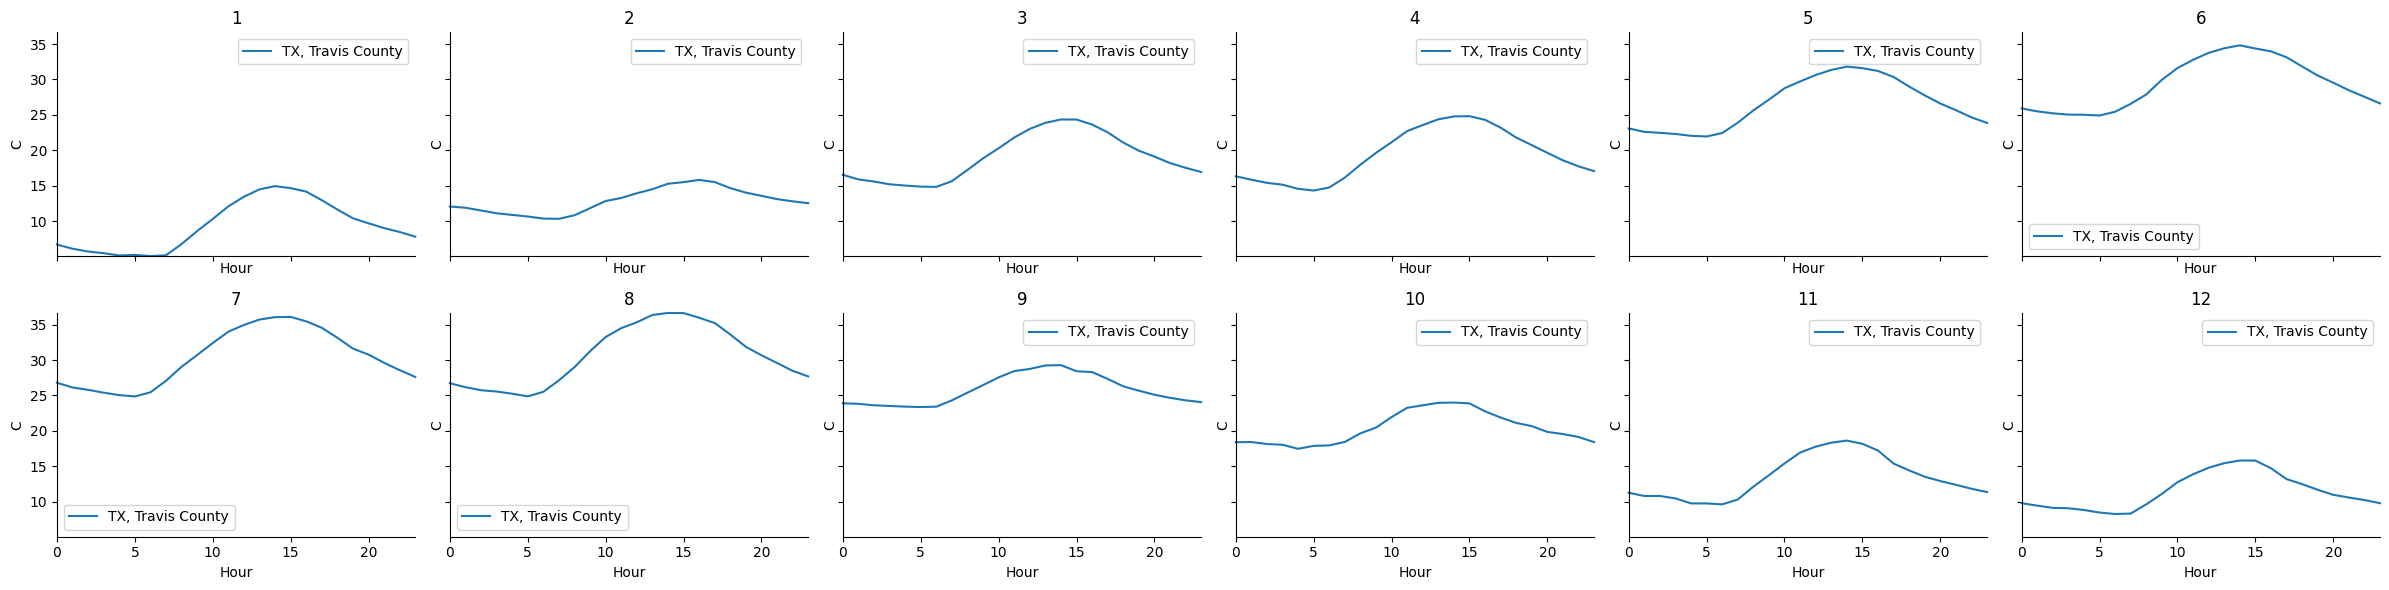

In [3]:
row_count, column_count = 2, 6
fig, _ = plt.subplots(row_count, column_count, figsize=(4*column_count, 3*row_count), sharex=True, sharey=True)

for n, d in zip(NEIGHBORHOOD_NAMES, NEIGHBORHOOD_DIRECTORIES):
    data = pd.read_csv(os.path.join(d, 'weather.csv'))
    data = pd.concat([data, TIMESTAMPS], axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hour'] = data['timestamp'].dt.hour
    data['month'] = data['timestamp'].dt.month
    
    for ax, (m, m_data) in zip(fig.axes, data.groupby('month')):
        m_data = m_data.groupby('hour')[['Outdoor Drybulb Temperature (C)']].mean()
        x, y = m_data.index, m_data['Outdoor Drybulb Temperature (C)']
        ax.plot(x, y, clip_on=False, label=n)

for i, ax in enumerate(fig.axes):
    ax.set_xlabel('Hour')
    ax.set_ylabel('C')
    ax.legend()
    ax.set_title(i + 1)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

- Travis county is warmest amongst the 3 counties
- Alameda county is too cold and below typical room temperature even during the summer so makes more sense analyze it in the winter.
- Chittenden county is also a bit cool in the summer so makes sense to analyze in the winter as well. Thus, only Travis county will be analyzed in the winter.

### Degree Days

In [4]:
baseline_temperature = 18.3 # C

for n, d in zip(NEIGHBORHOOD_NAMES, NEIGHBORHOOD_DIRECTORIES):
    data = pd.read_csv(os.path.join(d, 'weather.csv'))
    data = pd.concat([data, TIMESTAMPS], axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['date'] = data['timestamp'].dt.normalize()
    data = data.groupby('date')[['Outdoor Drybulb Temperature (C)']].mean()
    data['cdd'] = (data['Outdoor Drybulb Temperature (C)'] - baseline_temperature).clip(lower=0)
    data['hdd'] = (baseline_temperature - data['Outdoor Drybulb Temperature (C)']).clip(lower=0)
    print(n, ', CDD:', data['cdd'].sum(), ' HDD:', data['hdd'].sum())

TX, Travis County , CDD: 1820.9599305555553  HDD: 931.1723412698414


# Daily Load Profile

In [5]:
columns = ['Equipment Electric Power (kWh)', 'DHW Heating (kWh)', 'Cooling Load (kWh)', 'Heating Load (kWh)']
colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:red']
column_count_limit = 8

for n, d in zip(NEIGHBORHOOD_NAMES, NEIGHBORHOOD_DIRECTORIES):
    building_files = sorted([os.path.join(d, f) for f in os.listdir(d) if f.startswith('resstock')])
    row_count = math.ceil(len(building_files)/column_count_limit)
    column_count = min(column_count_limit, len(building_files))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, f in zip(fig.axes, building_files):
        data = pd.read_csv(f)
        data = pd.concat([data, TIMESTAMPS], axis=1)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data['date'] = data['timestamp'].dt.normalize()
        data = data.groupby('date')[columns].sum().reset_index()
        x = data['date']
        
        for c, o in zip(columns, colors):
            y = data[c]
            ax.plot(x, y, color=o)
            ax.set_title(f.split('-')[-1].split('.')[0])
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    fig.suptitle(n)
    plt.tight_layout()
    filename = f'{n.lower().replace(" ", "_").replace(",", "")}_daily_load_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

- The load profiles in Travis are consistent: relatively consistent plug and dhw loads through the year, dominant cooling load in the summer and some heating load in the winter and fall. All buildings have comparable load profiles for the same end-use.
- Inconsistencies in dominant loads for buildings in Alameda. Some buildings are cooling dominant while others are heating. Despite the cold weather, there are buildings cooling for almost the entire year.
- For the most part in Chittenden, buildings are heating dominant and space loads profiles are similar across buildings with very few exceptions.
- 91720 in Chittenden did not simulate for the full year; only 5 months were simulated.
- There are also spikes in the load profiles especially cooling and heating load for all county buildings. Suspect these odd profiles are as a result of the EMS changes made to get the ideal and partial load simulation results. Might need to do some outlier detection to remove spikes.

# Indoor Temperature

In [6]:
colors = ['tab:blue', 'tab:green', 'tab:red']
column_count_limit = 8

for n, d in zip(NEIGHBORHOOD_NAMES, NEIGHBORHOOD_DIRECTORIES):
    building_files = sorted([os.path.join(d, f) for f in os.listdir(d) if f.startswith('resstock')])
    row_count = math.ceil(len(building_files)/column_count_limit)
    column_count = min(column_count_limit, len(building_files))
    fig, _ = plt.subplots(row_count, column_count, figsize=(5*column_count, 2*row_count))

    for ax, f in zip(fig.axes, building_files):
        data = pd.read_csv(f)
        data = pd.concat([data, TIMESTAMPS], axis=1)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data['date'] = data['timestamp'].dt.normalize()
        data = data.groupby('date')[['Indoor Temperature (C)']].agg(['min', 'mean', 'max'])
        x = data.index
        
        for c, o in zip(data.columns, colors):
            y = data[c]
            ax.plot(x, y, color=o)
            ax.set_title(f.split('-')[-1].split('.')[0])
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    fig.suptitle(n)
    plt.tight_layout()
    filename = f'{n.lower().replace(" ", "_").replace(",", "")}_daily_temperature_profiles.pdf'
    plt.savefig(os.path.join(SETTINGS['figures_directory'], filename), bbox_inches='tight', transparent=True)
    plt.close()

# Miscellaneous

In [7]:
data = pd.read_csv('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/bs2023/data/simulation_output/travis/travis-environment.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data[data['episode']==3].copy()
building_names = data['building_name'].unique()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/bs2023/data/simulation_output/travis/travis-environment.csv'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
start_timestamp = '2018-06-01 00:00:00'
end_timestamp = '2018-06-2 23:00:00'
plot_data = data[
    (data['timestamp'] >= start_timestamp) 
    & (data['timestamp'] <= end_timestamp)
    & (data['building_name'] == building_names[3])
].copy()
x = plot_data['timestamp']
y1 = plot_data['net_electricity_consumption']
y2 = plot_data['net_electricity_consumption_without_storage']
y1 = plot_data['dhw_storage_soc']
y2 = plot_data['electrical_storage_soc']
ax.plot(x, y1, label='control')
ax.plot(x, y2, label='no control')
ax.legend()
plt.show()

In [ ]:
kpis = pd.read_csv('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/bs2023/data/simulation_output/travis/travis-kpi.csv')
kpis = kpis[kpis['level']=='district']
kpis.pivot(index='episode', columns='cost_function', values='value')